In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Causal Inference in Real Life (Between Classical ML and Causal Inference)

This will be our first practical example in using observational data to solve a particular business problem to aid business decision-making. In this example, we are going to be considering some major aspects in data analysis, RCTs, DAGs, and causal inference methods in solving business problems.

#### The Problem Scenario

Marketing selling campaigns constitute a typical strategy to enhance business. Companies use direct marketing to target specific customer segments by contacting them to achieve a specific goal. Centralising customer remote interactions in a contact centre eases operational management of campaigns. Such centers allow communicating with customers through various channels, telephone (fixed-line or mobile) being one of the most widely used. (Sérgio Moro, 2014).

### Solution

1.Statistical based method
2. Machine Learning Model for Correlation-based
3. Causal Inference (For Business Impact)

### Note

We know that using machine learning (ML) to predict whether a client will subscribe to a term deposit (which means they have committed a sum of money to the bank for a fixed period in exchange for a fixed interest rate) is crucial for banks. It helps banks with liquidity management, building customer relationships, maximizing profit, and more. An ML model can help predict which clients are likely to subscribe, enabling banks to optimize their strategy and decide which clients to contact with that particular offer.

However, using ML means learning to predict the future based on the past, and in reality, prediction does not solve every problem. Most of the time, we also want to understand how a particular policy or intervention impacts business outcomes. This leads us to causal inference.

The Causal Inference method will be used to understand the impact of using a **Contact Type** Treatment variable on the **Deposit Term** Outcome variable while keeping all other variables constant (making sure there is no correlation-based decision).

This section will focused more on general concept on becoming a **Business Data Scientist** from a statistician, ML, and Causal Inference point of view to explain the two ladders of causal inference better, and other subsequent sections will all be about using Causal Inference for decision-making.

#### DAG

https://dagitty.net/ for DAGs

https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/index.html#

In [69]:
%%capture
!pip install catboost
!pip install doubleml
!pip install dowhy
from IPython.display import Image, display
import pydot
import graphviz
#!pip install pygraphviz
#!pip install networkx==2.8.8
#import networkx as nx
#print(nx.__version__)

### Data Information

### 🧩 Features (Inputs)

#### Client data
- **age** *(numeric)*: Age of the client in years.  
- **job** *(categorical)*: Type of job, e.g. `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self‑employed`, `services`, `student`, `technician`, `unemployed`, `unknown`.  
- **marital** *(categorical)*: Marital status (`married`, `divorced` (or widowed), `single`, `unknown`).  
- **education** *(categorical)*: Education level (`basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`).  
- **default** *(categorical)*: Has credit in default? (`yes`, `no`, `unknown`).  
- **housing** *(categorical)*: Has a housing loan? (`yes`, `no`, `unknown`).  
- **loan** *(categorical)*: Has a personal loan? (`yes`, `no`, `unknown`).  

#### Campaign contact
- **contact** *(categorical)*: Contact communication type (`cellular`, `telephone`, `unknown`).  
- **month** *(categorical)*: Last contact month of the year (`jan`–`dec`).  
- **day_of_week** *(categorical)*: Last contact day of the week (`mon`–`fri`).  
- **duration** *(numeric)*: Duration of the last contact, in seconds. (*Note: strongly correlated with target; not known before call ends — use for benchmarking only*)

#### Campaign metrics
- **campaign** *(numeric)*: Number of contacts performed during this campaign (includes this last contact).  
- **pdays** *(numeric)*: Days since the client was last contacted from previous campaign (999 means not previously contacted).  
- **previous** *(numeric)*: Number of contacts performed before this campaign (prior campaigns).  
- **poutcome** *(categorical)*: Outcome of the previous marketing campaign (`failure`, `nonexistent`, `success`).  

#### Economic indicators
- **emp.var.rate** *(numeric)*: Employment variation rate (quarterly).  
- **cons.price.idx** *(numeric)*: Consumer Price Index (monthly).  
- **cons.conf.idx** *(numeric)*: Consumer Confidence Index (monthly).  
- **euribor3m** *(numeric)*: Euribor 3‑month rate (daily).  
- **nr.employed** *(numeric)*: Number of employees (quarterly).  

---

### 🎯 Target variable  
- **y** *(binary)*: Whether the client subscribed to a term deposit (`yes`, `no`).

**Take Note**

Take of this of Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import shap
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display

In [71]:
dir = '/content/drive/MyDrive/Nas-Causal-Inference-Project/'

In [72]:
df = pd.read_csv(dir + 'bank-additional-full.csv', sep=';')

In [73]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [74]:
print(df.shape)
print('We have {} observation in the dataset'.format(df.shape[0]))
print('We have {} feature in the dataset'.format(df.shape[1]))

(41188, 21)
We have 41188 observation in the dataset
We have 21 feature in the dataset


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [76]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [77]:
### Check duplicate values
print('We have {} duplicate values'.format(df[df.duplicated()].shape[0]))

We have 12 duplicate values


In [78]:
### Let us drop the duplicate values
df = df.drop_duplicates().reset_index(drop=True)

### EDA

Let Analysis some data

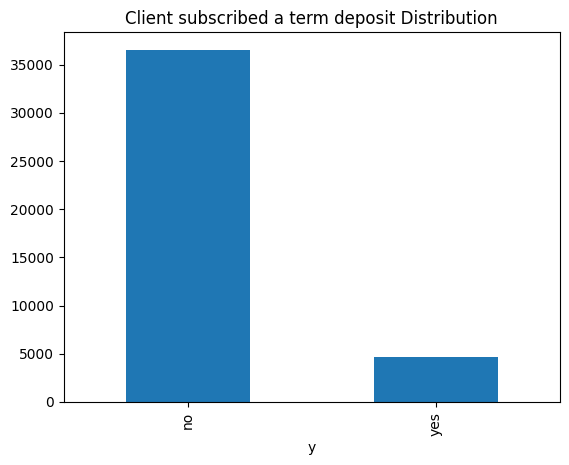

In [79]:
df['y'].value_counts().plot(kind='bar');
plt.title('Client subscribed a term deposit Distribution');

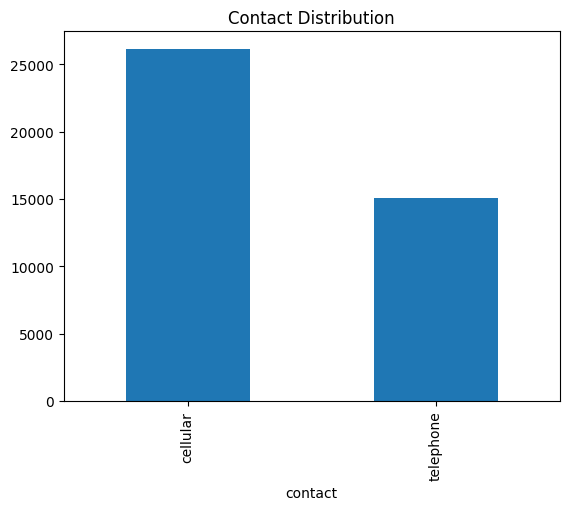

In [80]:
df['contact'].value_counts().plot(kind='bar');
plt.title('Contact Distribution');

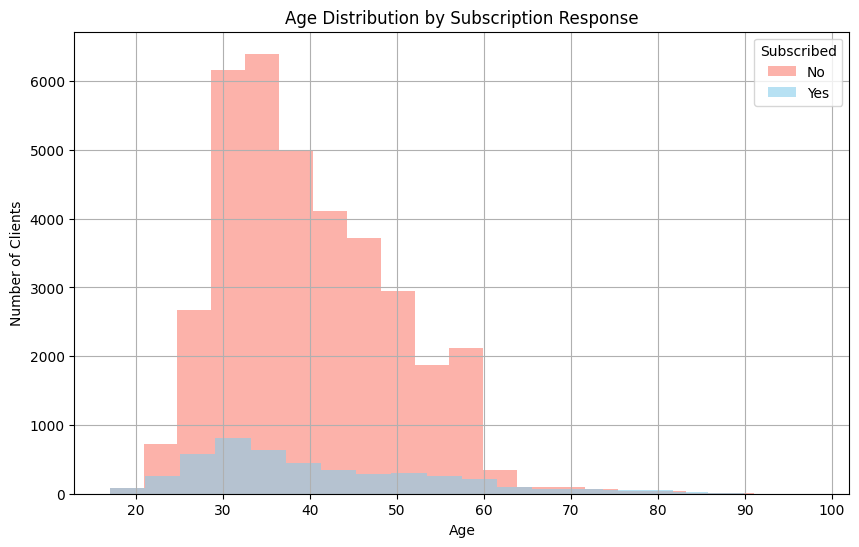

In [81]:
# Plot histograms for each response
plt.figure(figsize=(10, 6))
plt.hist(df[df['y'] == 'no']['age'], bins=20, alpha=0.6, label='No', color='salmon')
plt.hist(df[df['y'] == 'yes']['age'], bins=20, alpha=0.6, label='Yes', color='skyblue')

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.title('Age Distribution by Subscription Response')
plt.legend(title='Subscribed')
plt.grid(True)
plt.show()

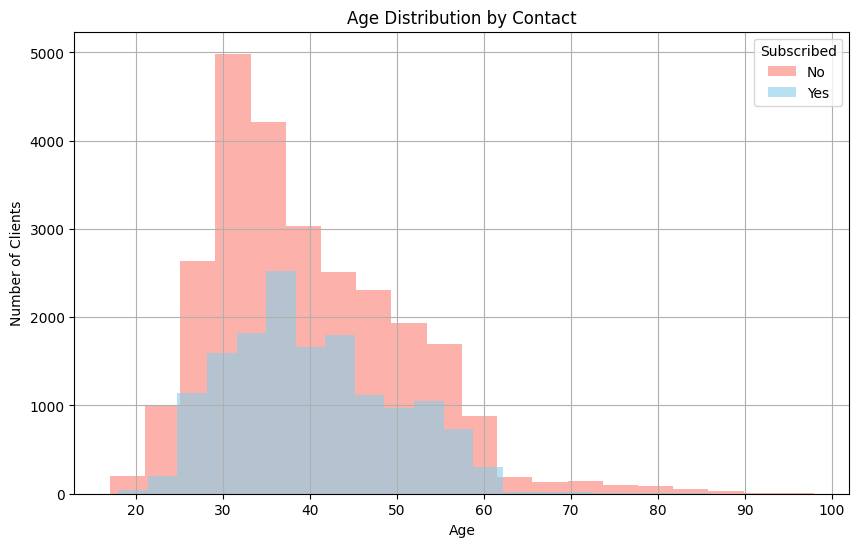

In [82]:
# Plot histograms for each response
plt.figure(figsize=(10, 6))
plt.hist(df[df['contact'] == 'cellular']['age'], bins=20, alpha=0.6, label='No', color='salmon')
plt.hist(df[df['contact'] == 'telephone']['age'], bins=20, alpha=0.6, label='Yes', color='skyblue')

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.title('Age Distribution by Contact')
plt.legend(title='Subscribed')
plt.grid(True)
plt.show()

In [83]:
for col in df.select_dtypes('O').columns:
    print('--------------------------------------------------')
    print(df[col].value_counts());

--------------------------------------------------
job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
--------------------------------------------------
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
--------------------------------------------------
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
--------------------------------------------------
default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
-------------------------------

#### Data Transformation

This is one of the process of handling your dataset for a ML or CI inference task.

In [84]:
### We are going to be using Contact Type in Causal Inference scenario
df['contact'] = df['contact'].map({"telephone":0, "cellular":1})
df['y'] = df['y'].map({"no":0, "yes":1})
df['default'] = df['default'].map({"no":0, "yes":1, 'unknown':-1})
df['housing'] = df['housing'].map({"no":0, "yes":1, 'unknown':-1})
df['loan'] = df['loan'].map({"no":0, "yes":1, 'unknown':-1})
df['poutcome'] = df['poutcome'].map({"failure":0, "success":1, 'nonexistent':-1})
df['month'] = df['month'].map({'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'mar':3, 'apr':4,'sep':9})
df['day_of_week'] = df['day_of_week'].map({'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5})
edu_map = {'unknown':-1, 'illiterate':0, 'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 'high.school':4, 'university.degree':5, 'professional.course':6}
df['education'] = df['education'].map(edu_map)
ord = OrdinalEncoder()
df['job'] = ord.fit_transform(df['job'].values.reshape(-1,1))

# .1 Statistical Modelling

In Statsitics, when we have a prediction problem we are mostly concerned about if the problem is a regression or classification problem, we should known that when we are modelling discrete variable it is **Classification** and for contineous variable it is **Regression**, but they have the same formular but the Response (y) are either {0,1,2,...,n} or {10.45, 11.89, 5000,...,n}.
For this problem our y is binary (i.e whether a client subscribed to bank deposit or not) in a yes(1) and no(0) option. In order to determine the performance of the model in statistical point of view is using In-Sample method (Model Inference. we can deduce the importance variables for our model using both the co-efficiecnt and p-values. Though this method usually used to suffer from model sparsity.

y = Bo + B1X1 + B2X2 + ... + BnXn

y --> Response

Bo --> Intercept

B1 --> Co-efficient

X --> Variables

In [85]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [86]:
y_s = df['y']
X_s = df.drop(['y', 'marital'], axis=1) ## Marital variable is a categorical variable left

In [87]:
X_s = sm.add_constant(X_s)

# Create and fit the model
model = sm.Logit(y_s, X_s)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.282133
         Iterations 8


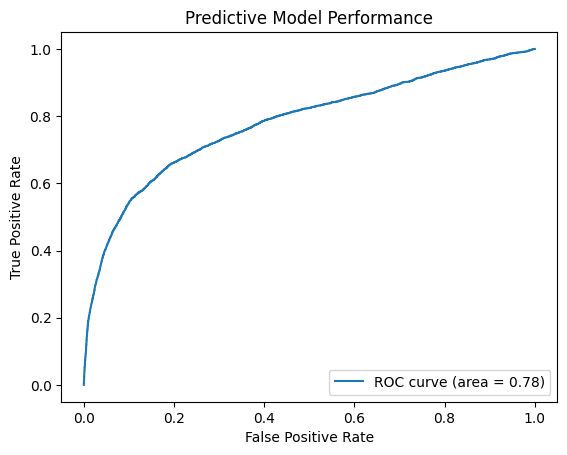

In [88]:
# Get predictions
y_pred = result.predict(X_s)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_s, y_pred)
roc_auc = roc_auc_score(y_s, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predictive Model Performance')
plt.legend(loc="lower right")
plt.show()

In [89]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41157
Method:                           MLE   Df Model:                           18
Date:                Wed, 16 Jul 2025   Pseudo R-squ.:                  0.1986
Time:                        15:51:22   Log-Likelihood:                -11617.
converged:                       True   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -87.9343     15.670     -5.612      0.000    -118.647     -57.222
age                0.0034      0.002      2.253      0.024       0.000       0.006
job                0.0068      0.005

In [90]:
lr_model_odd = (np.exp(result.params).round(2)).reset_index().rename(columns={'index':'features', 0:'odd_ratio'})

In [91]:
lr_model_odd[lr_model_odd['odd_ratio'] > 1.00]['features'].to_list()

['job',
 'education',
 'default',
 'contact',
 'day_of_week',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m']

### What Business can deduce from Statistical Point of View

* There is 93% accuracy model performance when using in-sample evaluation.
* If the bank did not take any action, a lot of clients will subscribed for bank deposit (~-84 constant value)
* Variables like **Loan**, **Month**, **Campaign**, **Previous**, **POutcome**, **Number of Employed**, and **employment rate** shows that they have negative correlation with the Response (i.e As they increase, the probability of client subscribing for bank deposit decrease).
* Variables like **Job**, **Education**, **Housing**, **Contact**, **Day of week**, **Consumer Price Index**, **cons.conf.idx**, and **euribor3m** have positive correlation with the Response i.e As they increase, the probability of client subscribing for bank deposit also Increases)
* Variables like **Pdays**, **Duration**, and **Age** have no effect on decision making, but that does not mean they have to be excluded from the variables considered.
* Only Variables like **Housing**, **Loan**,  and **Day of Week** are not statistically significant (i.e P-values > 0.05)

In [92]:
mdf = pd.get_dummies(df, drop_first=True, dtype=int)

In [93]:
my_s = mdf['y']
mX_s = mdf.drop('y', axis=1)

In [94]:
mX_s = sm.add_constant(mX_s)

# Create and fit the model
model_m = sm.Logit(my_s, mX_s)
result1 = model_m.fit()

Optimization terminated successfully.
         Current function value: 0.215557
         Iterations 9


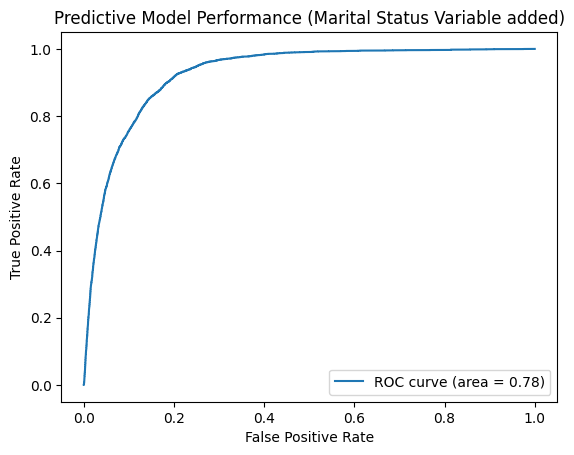

In [95]:
# Get predictions
y_pred1 = result1.predict(mX_s)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(my_s, y_pred1)
roc_auc = roc_auc_score(my_s, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predictive Model Performance (Marital Status Variable added)')
plt.legend(loc="lower right")
plt.show()

In [96]:
print(result1.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41153
Method:                           MLE   Df Model:                           22
Date:                Wed, 16 Jul 2025   Pseudo R-squ.:                  0.3877
Time:                        15:51:23   Log-Likelihood:                -8875.8
converged:                       True   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -82.0002     18.249     -4.493      0.000    -117.768     -46.232
age                 0.0076      0.002      4.007      0.000       0.004       0.011
job                 0.0100      

# .2 Machine Learning

Machine learning usually evaluates model performance using out-of-sample (OOS) distribution (i.e., we split our data into training and validation data); the model performance on the validation data will show how our model behaves with unseen data.

In [97]:
### let me use the mdf data
mX_s = mX_s.drop('const', axis=1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(mX_s, y_s, test_size=0.2, random_state=101)

In [99]:
ml_model = CatBoostClassifier(eval_metric='AUC',metric_period=100)

In [100]:
ml_model.fit(X_train, y_train, eval_set= [(X_train, y_train),(X_test, y_test)])

Learning rate set to 0.075125
0:	test: 0.8944173	test1: 0.9016250	best: 0.9016250 (0)	total: 63ms	remaining: 1m 2s
100:	test: 0.9537661	test1: 0.9529562	best: 0.9529562 (100)	total: 1.33s	remaining: 11.8s
200:	test: 0.9605519	test1: 0.9545236	best: 0.9545236 (200)	total: 3.01s	remaining: 11.9s
300:	test: 0.9654205	test1: 0.9548107	best: 0.9548107 (300)	total: 6.15s	remaining: 14.3s
400:	test: 0.9695034	test1: 0.9544500	best: 0.9548107 (300)	total: 10.4s	remaining: 15.5s
500:	test: 0.9729315	test1: 0.9543657	best: 0.9548107 (300)	total: 14.2s	remaining: 14.2s
600:	test: 0.9757760	test1: 0.9542929	best: 0.9548107 (300)	total: 17.6s	remaining: 11.7s
700:	test: 0.9781093	test1: 0.9539838	best: 0.9548107 (300)	total: 20.6s	remaining: 8.78s
800:	test: 0.9805506	test1: 0.9538166	best: 0.9548107 (300)	total: 24s	remaining: 5.97s
900:	test: 0.9825578	test1: 0.9537037	best: 0.9548107 (300)	total: 28.8s	remaining: 3.17s
999:	test: 0.9842297	test1: 0.9535851	best: 0.9548107 (300)	total: 31.4s	rema

In [101]:
y_cat = ml_model.predict_proba(X_test)[:,1]

In [102]:
y_cat

array([3.21990018e-04, 1.59036174e-02, 5.45336302e-05, ...,
       6.28183978e-01, 5.93236909e-01, 3.82053261e-03])

In [103]:
roc_auc_score(y_test, y_cat)

np.float64(0.9548107412397631)

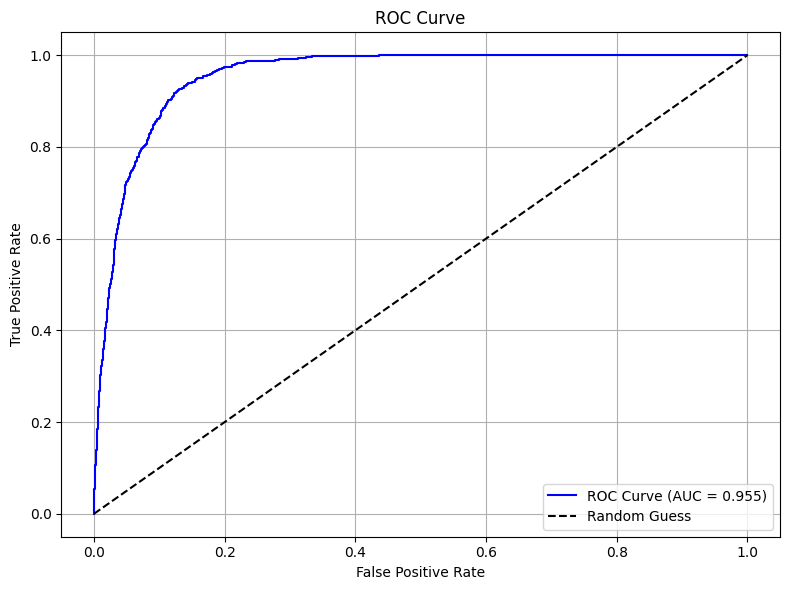

In [104]:
# Calculate AUC
auc = roc_auc_score(y_test, y_cat)

# Get false positive rate, true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_cat)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

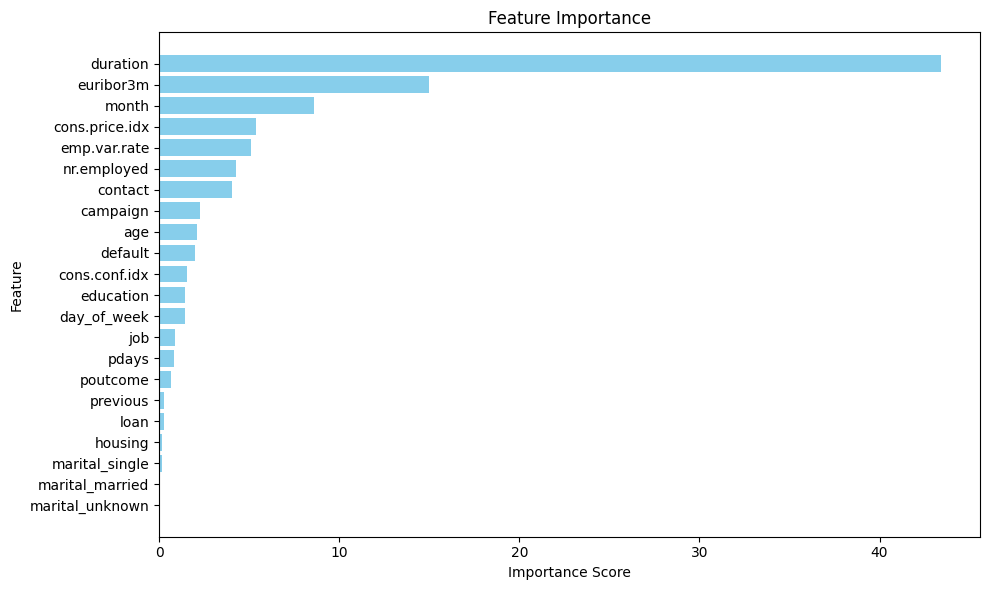

In [105]:
# Get feature importance and names
feature_importance = ml_model.get_feature_importance()
feature_names = mX_s.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot in order
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()

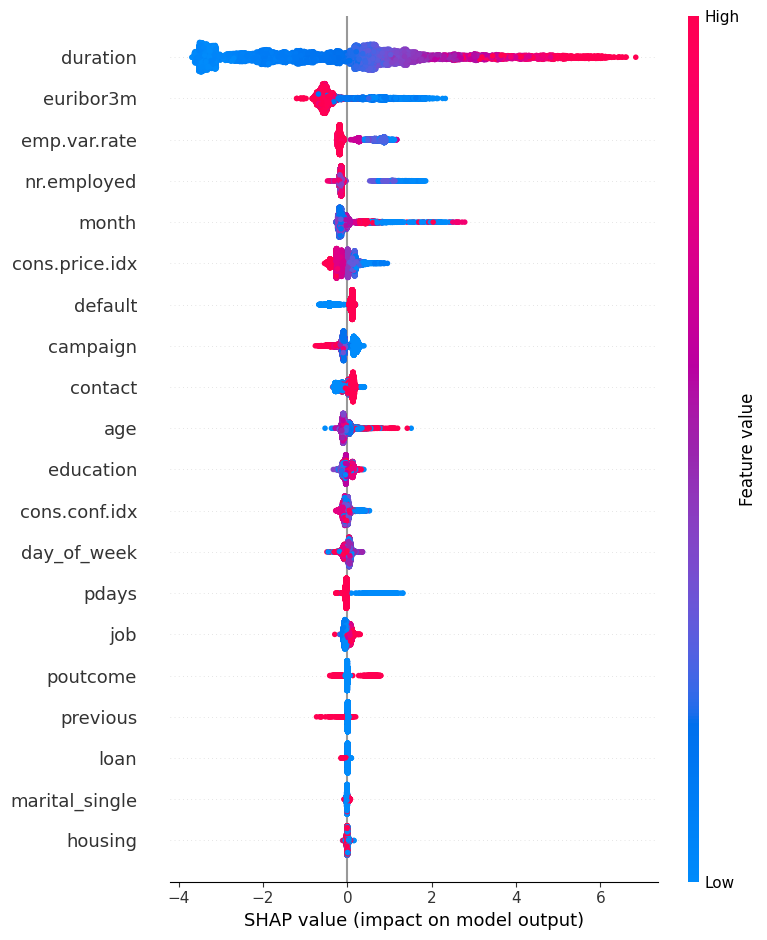

In [106]:
# Get SHAP values
explainer = shap.TreeExplainer(ml_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=mX_s.columns)

### What Business can deduce from Machine Learning using Interpretable ML techniques Point of View
* Higher call duration increased the chance of clients subscribing to bank deposit.
* When the social economic features are lower, it increased of clients subscribing to bank deposits.
* Those who default credit tends to subscribed to bank deposit.
* Older clients tends to subscribed to bank deposit than younger clients.
* Highly educated clients tends to subscribed to bank deposit than low educated clients.
* Those clinets contacted with Cellular tends to subscribed to bank deposit than those with Telephone.

*Questions*
1. Show the bank invest more spending more time with their client?
2. Should all credit defaults have been giving the offer?

# .3 Causal Inference



In [107]:
df.groupby('y')['duration'].mean()

,duration
y,
0,220.868079
1,553.256090


In [108]:
df.groupby('contact')['duration'].mean()

,duration
contact,
0,249.201449
1,263.561240


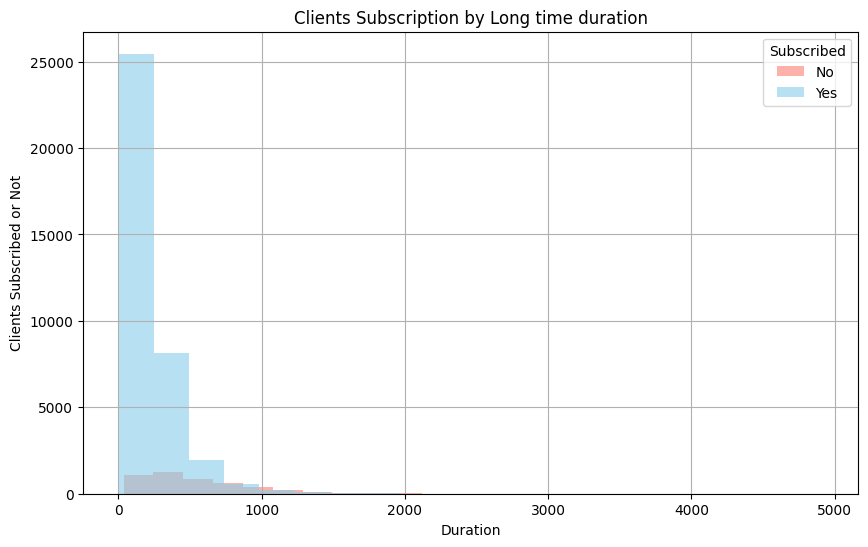

In [109]:
# Plot histograms for each response
plt.figure(figsize=(10, 6))
plt.hist(df[df['y'] == 1]['duration'], bins=20, alpha=0.6, label='No', color='salmon')
plt.hist(df[df['y'] == 0]['duration'], bins=20, alpha=0.6, label='Yes', color='skyblue')

# Add labels and legend
plt.xlabel('Duration')
plt.ylabel('Clients Subscribed or Not')
plt.title('Clients Subscription by Long time duration')
plt.legend(title='Subscribed')
plt.grid(True)
plt.show()

### Making a wrong decision with data

E[y|T=1] - E[y|T=0] = ATE

Note:
y = Whether a client subscribed to a bank deposit or not

T = The Contact used by the Bank

In [110]:
(df[df['contact'] == 1]['y'].mean() - df[df['contact'] == 0]['y'].mean())*100

np.float64(9.506491070952837)

#### Naive Conclusion

* Clients who communicated through the cellular contact method have a 9.51% increased chance of subscribing to bank deposits.
* Should the bank communicate more with the clients through cellular contact types to increase bank deposit types?
* This is what exactly our correlation-based method gives us, when we used Interpretable ML.

#### Wrong Conclusion

This naive difference in means assumes random assignment of treatment (T = contact method). But in real-world datasets, especially observational ones like a bank marketing dataset. E[y|T=1] - E[y|T=0] != ATE (when treatments are not randomly assigned). We have seen how this type of method fails when we use simulated data (when we already know our true ATE).


### Let us take the Unconfoundedness (Ignorability) assumption into consideration

1. Included likelihood confounding variable with OLS (It is not neccessary to use Logistics regression here, because we are interested in ATE=E[Y(1)−Y(0)]) --> y = Bo + v0(Treatment) + Confounding Variables
2. Data Generating Processes
3. Using Double ML to estimate the ATE

In [111]:
ols_result = smf.ols('y ~ contact + age + job + education', data=df).fit()
ols_result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0011,0.008,-0.136,0.892,-0.016,0.014
contact,0.0942,0.003,29.316,0.000,0.088,0.101
age,0.0010,0.000,6.703,0.000,0.001,0.001
job,0.0017,0.000,3.998,0.000,0.001,0.003
education,0.0019,0.001,2.067,0.039,9.71e-05,0.004


In [112]:
# Logistic regression
logit_model = smf.ols('y ~ contact + age + job + education', data=df).fit()
print(logit_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.008     -0.136      0.892      -0.016       0.014
contact        0.0942      0.003     29.316      0.000       0.088       0.101
age            0.0010      0.000      6.703      0.000       0.001       0.001
job            0.0017      0.000      3.998      0.000       0.001       0.003
education      0.0019      0.001      2.067      0.039    9.71e-05       0.004


In [113]:
causal_graph_clean = """
digraph {
    age -> contact;
    age -> y;

    job -> contact;
    job -> y;

    education -> contact;
    education -> y;

    campaign -> contact;
    campaign -> y;

    pdays -> contact;
    pdays -> y;

    previous -> contact;
    previous -> y;

    poutcome -> contact;
    poutcome -> y;

    contact -> y;

    contact -> duration;
    duration -> y;

    default -> y;
    housing -> y;
    loan -> y;

    emp.var.rate -> y;
    cons.price.idx -> y;
    cons.conf.idx -> y;
    euribor3m -> y;
    nr.employed -> y;

    month -> y;
    day_of_week -> y;
    marital -> y;
}
"""


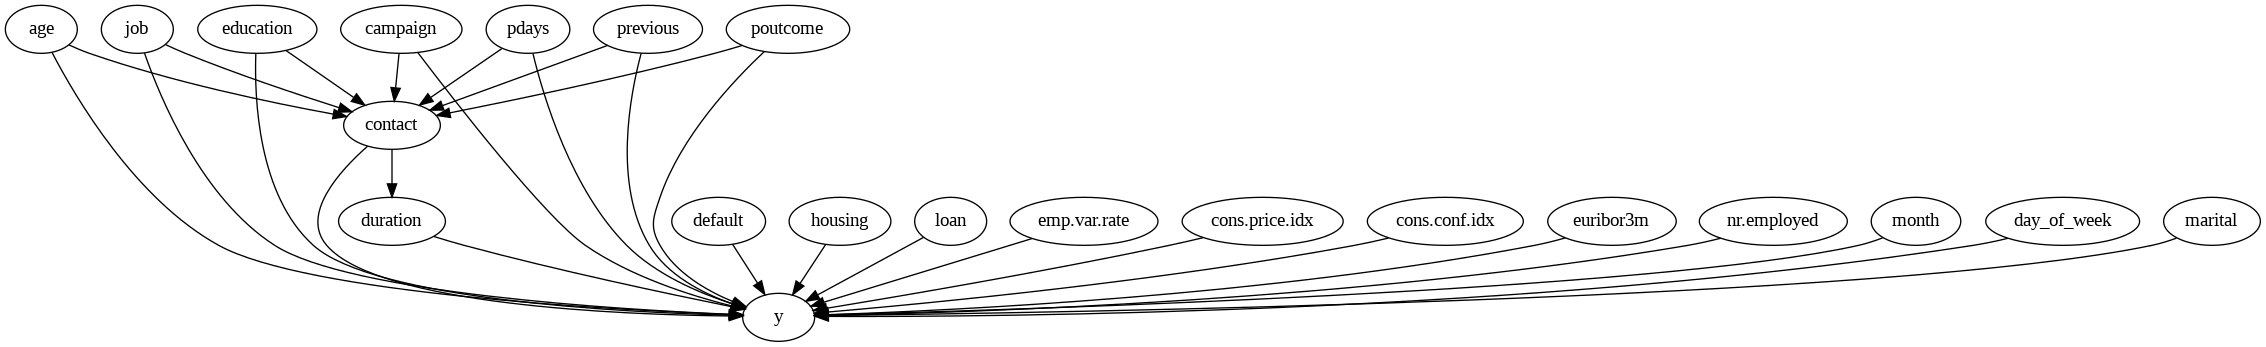

In [114]:
import pydot
from IPython.display import Image

# Save the DOT file
with open("dag.dot", "w") as f:
    f.write(causal_graph_clean)

# Render it with pydot
(graph,) = pydot.graph_from_dot_file("dag.dot")
graph.write_png("dag.png")

# Display in notebook
Image(filename="dag.png")

In [115]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [116]:
unc_df = df[['y', 'contact', 'age', 'job', 'education', 'campaign', 'pdays',
       'previous', 'poutcome']]

In [117]:
#!pip install doubleml

In [118]:
from doubleml import DoubleMLData, DoubleMLPLR
from sklearn.linear_model import LinearRegression

In [119]:
unc_df.columns[2:].to_list()

['age', 'job', 'education', 'campaign', 'pdays', 'previous', 'poutcome']

In [120]:
dml_data = DoubleMLData(unc_df, y_col="y", d_cols="contact", x_cols=unc_df.columns[2:].to_list())

# Define the machine learning models for the nuisance parameters (outcome and treatment models)
ml_model_t =  LGBMRegressor(verbosity=-1) #LGBMClassifier(verbosity=-1) #LGBMRegressor() #LinearRegression()
ml_model_y = LGBMRegressor(verbosity=-1) #LGBMClassifier(verbosity=-1) #LGBMRegressor() #LinearRegression()

# Define the DoubleML model with the chosen machine learning models
dml_model = DoubleMLPLR(dml_data, ml_model_y, ml_model_t)

# Fit the model
dml_model.fit()

# Estimate the ATE (Average Treatment Effect)
ate = dml_model.coef
print("Estimated ATE:", ate);

Estimated ATE: [0.05765286]


In [121]:
dml_model.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
contact,0.057653,0.002834,20.345773,5.060829e-92,0.052099,0.063207


#### Conclusion

* Clients who communicated through the cellular contact method have a 5.7% increased chance of subscribing to bank deposits.
* Using the cellular method has a positive impact on clients subscribing to bank deposits.

In [122]:
causal_graph = """
digraph {
    age -> contact;
    age -> y;

    job -> contact;
    job -> y;

    education -> contact;
    education -> y;

    campaign -> contact;
    campaign -> y;

    pdays -> contact;
    pdays -> y;

    previous -> contact;
    previous -> y;

    poutcome -> contact;
    poutcome -> y;

    # treatment -> outcome
    contact -> y;

    # post-treatment (do NOT adjust for these)
    contact -> duration;
    duration -> y;

    # outcome-only predictors (not confounders)
    default -> y;
    housing -> y;
    loan -> y;

    emp.var.rate -> y;
    cons.price.idx -> y;
    cons.conf.idx -> y;
    euribor3m -> y;
    nr.employed -> y;

    month -> y;
    day_of_week -> y;
}
"""


In [123]:
model= CausalModel(
        data = df,
        graph=causal_graph_clean,#causal_graph.replace("\n", " "),
        treatment='contact',
        outcome='y')
#model.view_model()
#model.view_model(filename="dag.dot", format="dot")

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


In [124]:
estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
──────────(E[y|education,campaign,previous,job,pdays,age,poutcome])
d[contact]                                                         
Estimand assumption 1, Unconfoundedness: If U→{contact} and U→y then P(y|contact,education,campaign,previous,job,pdays,age,poutcome,U) = P(y|contact,education,campaign,previous,job,pdays,age,poutcome)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                                                              
──────────(E[y|poutcome,campaign,job,pdays,age,previous,education])
d[contact]                                                         
Estimand assumption 1, Unconfoundedness: If U→{contact} and U→y then P(y|con

In [125]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)
print(round(estimate. value, 5))
estimate.interpret()

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
──────────(E[y|education,campaign,previous,job,pdays,age,poutcome])
d[contact]                                                         
Estimand assumption 1, Unconfoundedness: If U→{contact} and U→y then P(y|contact,education,campaign,previous,job,pdays,age,poutcome,U) = P(y|contact,education,campaign,previous,job,pdays,age,poutcome)

## Realized estimand
b: y~contact+education+campaign+previous+job+pdays+age+poutcome
Target units: ate

## Estimate
Mean value: 0.05921518389565844

0.05922


In [126]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

Refute: Add a random common cause
Estimated effect:0.05921518389565844
New effect:0.05921518389565847
p value:1.0



In [127]:
refutel = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.05921518389565844
New effect:0.05975236126900968
p value:0.78

